<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/CreditCard_LogisticRegression_UnderSample_OverSample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import library

In [0]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_curve, auc

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot
import matplotlib.pyplot as plt

## Step 1: Load data

In [58]:
# need to upload data from local manually
data = pd.read_csv('/content/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [59]:
data.shape

(284807, 31)

## Step 2: Feature Engineering

This section will include feature preprocessing, such as feature combinaiton, convertion, etc.

In [60]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
count_classes = pd.value_counts(data["Amount"], sort = True).sort_index()
#count_classes

1. The feature **Time** seems not to be related to the target varaible **Class**, will drop "Time".
2. The range of of the feature **Amount** vary a lot from 0 to 25691,  need to standardize it.  

### 1.Standardize feature "Amount" and drop "Time"

In [62]:
from sklearn.preprocessing import StandardScaler
data["normAmount"] = StandardScaler().fit_transform(data[["Amount"]]).reshape(-1, 1)
data = data.drop(["Amount", "Time"], axis = 1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 2. About the target variable, Class (0 & 1)

#### 2.1 check the rows when target variable is null and drop the rows

In [0]:
#print(data.isnull().sum())
data = data.dropna(axis=0, subset=['Class'])
#print(data.isnull().sum())

#### 2.2 check the distribution of the target variable

The sample size of the target variable is imbalance. 

Next, I will run the models based on different conditions to compare the performances.

1. Run the model with the original dataset (imbalanced dataset)

2. Use under-sampling (下采样) to balance the sample sizes between the two classes, and fit the model, and get the performance.

3. Use over-sampling (过采样) to balance the sample size betwee the two classes, and fit the model, and get the performance.

0    284315
1       492
Name: Class, dtype: int64


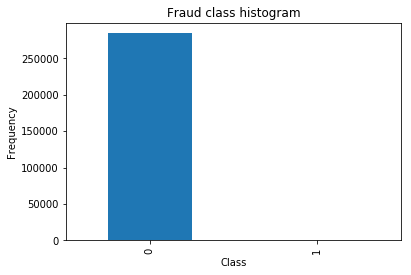

In [64]:
count_classes = pd.value_counts(data["Class"], sort = True).sort_index()
print(count_classes)
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

## Step 3: Modeling

In [65]:
X = data.drop(["Class"], axis = 1)
Y = data["Class"]
# get the train, test datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

print("Number of transactions train dataset:", len(x_train))
print("Number of transactions test dataset:", len(x_test))
print("The total number of transactions:", len(X))

Number of transactions train dataset: 227845
Number of transactions test dataset: 56962
The total number of transactions: 284807


### Model 1. Model with the imbalanced original dataset (class 0 : class 1 = 228:1)

In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#### 1. Model fitting for the imbalanced dataset

In [0]:
def print_Kfold_score(x_train, y_train):
  kf = KFold(n_splits = 5, shuffle = False)

  # different C parameters
  c_params_range = [0.01, 0.1, 1, 10, 100]
  results_table = pd.DataFrame(index = range(len(c_params_range), 2), columns = ["C_parameter", "Mean_recall_score"])
  results_table["C_parameter"] = c_params_range

  # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
  i = 0
  for c_param in c_params_range:
    print("-" * 20)
    print("C_Parameter:", c_param)
    print("-" * 20)
    print()

    recall_accs = []
    for iteration, indices in enumerate(kf.split(x_train, y_train), start = 1):
      # call the logistic regression model with a certain C Parameter
      lr = LogisticRegression(C = c_param, penalty = "l1")
      # Use the training data to fit the model. In this case, I will use the portion of the fold to train the model
      # with indices[0], I predict on the portion assigned as the "test cross validation" 
      lr.fit(x_train.iloc[indices[0], :], y_train.iloc[indices[0]])
      # predict values using the test indices in the training data
      y_pred = lr.predict(x_train.iloc[indices[1]])                                  

      # calculate the recall score and append it to a list for recall scores representing the current 
      recall_acc = recall_score(y_train.iloc[indices[1]], y_pred)
      recall_accs.append(recall_acc)
      print("Iteration:", iteration, ", recall score = ", recall_acc)

    # the mean value of those recall scores is the metric we want to save and get hold of
    results_table.loc[i, "Mean_recall_score"] = np.mean(recall_accs)
    i += 1
    print()
    print("Mean recall score", np.mean(recall_accs))
    print()

  best_c = results_table.loc[results_table["Mean_recall_score"].astype(float).idxmax()]["C_parameter"]

  # finally, we can check which C parameter is the best among the chosen

  print("*" * 20)
  print("Best model to choose from cross validation is with C parameter = ", best_c)
  print("*" * 20)
  return best_c  
      

In [68]:
best_c = print_Kfold_score(x_train, y_train)

--------------------
C_Parameter: 0.01
--------------------

Iteration: 1 , recall score =  0.5066666666666667
Iteration: 2 , recall score =  0.575
Iteration: 3 , recall score =  0.6
Iteration: 4 , recall score =  0.6233766233766234
Iteration: 5 , recall score =  0.4523809523809524

Mean recall score 0.5514848484848486

--------------------
C_Parameter: 0.1
--------------------

Iteration: 1 , recall score =  0.5466666666666666
Iteration: 2 , recall score =  0.6125
Iteration: 3 , recall score =  0.64
Iteration: 4 , recall score =  0.6623376623376623
Iteration: 5 , recall score =  0.4880952380952381

Mean recall score 0.5899199134199135

--------------------
C_Parameter: 1
--------------------

Iteration: 1 , recall score =  0.5333333333333333
Iteration: 2 , recall score =  0.625
Iteration: 3 , recall score =  0.6533333333333333
Iteration: 4 , recall score =  0.6753246753246753
Iteration: 5 , recall score =  0.5476190476190477

Mean recall score 0.6069220779220779

--------------------


From the results above, the best performance (mean recall score) is about 0.62 when C_parameter = 10.

This performance is not high enough to be a good model.

Next, I will use the under_sampling method to balance the sample sizes and analyze the performance (mean recall score) again.

**Note**: could also compare the accuracy. But the accuracy is usually not a good indicator of model performance, especially when the dataset is imbalanced. 

#### 2. More analysis about recall score, and accuracy

Recall_score = TP / (TP + FN)

Accuracy = (TP + TN) / len(dataset)

In [69]:
lr = LogisticRegression(C = best_c, penalty = "l1")
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)

print("Recall score in the testing dataset:", cnf_matrix[1, 1]/(cnf_matrix[1, 0] + cnf_matrix[1, 1]))
print("Accuracy in the testing dataset:", (cnf_matrix[0, 0] + cnf_matrix[1, 1])/(len(x_test)))

Recall score in the testing dataset: 0.6435643564356436
Accuracy in the testing dataset: 0.9992099996488887


Even though the accuracy is very high, the recall score is low. This is because the dataset is very imbalanced.

In [0]:
def plot_confusion_matrix(cm, title = "Confusion matrix", cmap = plt.cm.Wistia):
  """
  This function prints and plots the confusion matrix
  """
  plt.figure(figsize = (6, 6))
  plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Wistia) # plt.cm.Blues
  plt.title("Confusion Matrix", size = 14)
  plt.colorbar()
  tick_marks = np.arange(2) # len(classes)
  plt.xticks(tick_marks,rotation = 0)
  plt.yticks(tick_marks,rotation = 0)
  plt.xlabel('Predicted class', size = 12)
  plt.ylabel('True class', size = 12)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
    for j in range(2):
      plt.text(j, i, str(s[i][j]+ "=" + str(cm[i][j]) ), size = 10)
  plt.show()

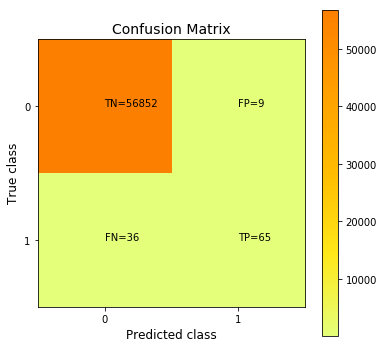

In [71]:
plot_confusion_matrix(cnf_matrix, title = "Confusion matrix", cmap = plt.cm.Wistia)

### Model 2. Model with under_sampling to balance the dataset 

#### 1. 下采样 (同样少）
To drop the class with more samples to make the sample size equal to that of the class with less samples

In [72]:
# get the indices for the data points in the minority class
number_records_fraud = len(y_train[y_train == 1])
fraud_indices = np.array(y_train[y_train == 1].index)

# get the indices of the normal classes
normal_indices = y_train[y_train == 0].index

# out of the indices of normal classes, randomly select "X" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset

under_sample_data = data.iloc[under_sample_indices, :]

us_x = under_sample_data.iloc[:, under_sample_data.columns != "Class"]
us_y = under_sample_data.iloc[:, under_sample_data.columns == "Class"]

# Showing ratio
print("Percentage of normal transactions:", len(us_y[us_y["Class"] == 0])/len(us_y))
print("Percentage of unnormal transactions:", len(us_y[us_y["Class"] == 1])/len(us_y))
print("Total number of transactions in resampled data:", len(us_y))

Percentage of normal transactions: 0.5
Percentage of unnormal transactions: 0.5
Total number of transactions in resampled data: 782


In [73]:
best_c = print_Kfold_score(us_x, us_y)

--------------------
C_Parameter: 0.01
--------------------

Iteration: 1 , recall score =  0.8726114649681529
Iteration: 2 , recall score =  0.8853503184713376
Iteration: 3 , recall score =  0.961038961038961
Iteration: 4 , recall score =  0.0
Iteration: 5 , recall score =  0.0

Mean recall score 0.5438001488956903

--------------------
C_Parameter: 0.1
--------------------

Iteration: 1 , recall score =  0.8598726114649682
Iteration: 2 , recall score =  0.8853503184713376
Iteration: 3 , recall score =  0.922077922077922
Iteration: 4 , recall score =  0.0
Iteration: 5 , recall score =  0.0

Mean recall score 0.5334601704028457

--------------------
C_Parameter: 1
--------------------

Iteration: 1 , recall score =  0.8789808917197452
Iteration: 2 , recall score =  0.8980891719745223
Iteration: 3 , recall score =  0.935064935064935
Iteration: 4 , recall score =  0.0
Iteration: 5 , recall score =  0.0

Mean recall score 0.5424269997518405

--------------------
C_Parameter: 10
----------

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Iteration: 1 , recall score =  0.8789808917197452
Iteration: 2 , recall score =  0.8980891719745223
Iteration: 3 , recall score =  0.935064935064935
Iteration: 4 , recall score =  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/loc

Iteration: 5 , recall score =  0.0

Mean recall score 0.5424269997518405

--------------------
C_Parameter: 100
--------------------

Iteration: 1 , recall score =  0.8726114649681529


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.8980891719745223
Iteration: 3 , recall score =  0.935064935064935
Iteration: 4 , recall score =  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.0

Mean recall score 0.541153114401522

********************
Best model to choose from cross validation is with C parameter =  0.01
********************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


With the under_sampling, the sample size becomes very small, 984 in total. And the recall_scores are very unstable.

#### 2. More analysis about recall score, and accuracy

Recall_score = TP / (TP + FN)

Accuracy = (TP + TN) / len(dataset)

In [74]:
lr = LogisticRegression(C = best_c, penalty = "l1")
lr.fit(us_x, us_y)
y_pred = lr.predict(x_test)
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)

print("Recall score in the testing dataset:", cnf_matrix[1, 1]/(cnf_matrix[1, 0] + cnf_matrix[1, 1]))
print("Accuracy in the testing dataset:", (cnf_matrix[0, 0] + cnf_matrix[1, 1])/(len(x_test)))

Recall score in the testing dataset: 0.9306930693069307
Accuracy in the testing dataset: 0.9405919735964328


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


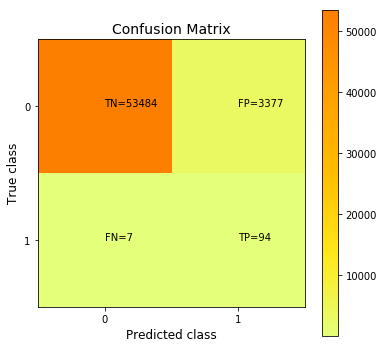

In [75]:
plot_confusion_matrix(cnf_matrix, title = "Confusion matrix", cmap = plt.cm.Wistia)

Compred to the original dataset, from the results above, the recall score increases, but the accuracy decrease. 

In addition, to increase the recall score, the FP increases significantly, which would make great impact practically.

For example, practically,  for the predicted unnormal cases, the bank would investigate the unnormal cases one by one. 


Thus, even though the FP will not impact our recall score much, it will impack the practical conditions a lot. 


The performance of the under_sampling is not good. 

### Model 3. Model with over_sampling to balance the dataset (SMOTE)

#### 1. 过采样 (同样多)

To resample the class with less samples to make the sample size equal to that of the class with more smaples

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
oversample = SMOTE(random_state = 0)
os_x, os_y = oversample.fit_sample(x_train, y_train)

In [78]:
print("The sample size when Class = 1:", len(os_y[os_y == 1]))
print("The sample size when Class = 0:", len(os_y[os_y == 0]))

The sample size when Class = 1: 227454
The sample size when Class = 0: 227454


In [79]:
os_x = pd.DataFrame(os_x)
os_y = pd.DataFrame(os_y)

simplefilter(action='ignore', category=FutureWarning)
best_c = print_Kfold_score(os_x, os_y)

--------------------
C_Parameter: 0.01
--------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 1 , recall score =  0.9161290322580645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.9144736842105263


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 3 , recall score =  0.9098152041606727


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 4 , recall score =  0.8918565414756927


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.8927248546399797

Mean recall score 0.9049998633489873

--------------------
C_Parameter: 0.1
--------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 1 , recall score =  0.9161290322580645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.9144736842105263


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 3 , recall score =  0.9111873409317252


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 4 , recall score =  0.8941537244039964


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.8944394983567998

Mean recall score 0.9060766560322225

--------------------
C_Parameter: 1
--------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 1 , recall score =  0.9161290322580645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.9144736842105263


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 3 , recall score =  0.911297997122939


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 4 , recall score =  0.8943955331332916


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.8950989767094228

Mean recall score 0.9062790446868488

--------------------
C_Parameter: 10
--------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 1 , recall score =  0.9161290322580645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.9144736842105263


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 3 , recall score =  0.9113201283611818


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 4 , recall score =  0.8944175157450457


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.895131950627054

Mean recall score 0.9062944622403745

--------------------
C_Parameter: 100
--------------------



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 1 , recall score =  0.9161290322580645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 2 , recall score =  0.9144736842105263


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 3 , recall score =  0.9113201283611818


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 4 , recall score =  0.8942856200745211


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration: 5 , recall score =  0.8951539332388081

Mean recall score 0.9062724796286205

********************
Best model to choose from cross validation is with C parameter =  10.0
********************


#### 2. More analysis about recall score, and accuracy

In [80]:
lr = LogisticRegression(C = best_c, penalty = "l1")
lr.fit(os_x, os_y)
y_pred = lr.predict(x_test)
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)

print("Recall score in the testing dataset:", cnf_matrix[1, 1]/(cnf_matrix[1, 0] + cnf_matrix[1, 1]))
print("Accuracy in the testing dataset:", (cnf_matrix[0, 0] + cnf_matrix[1, 1])/(len(x_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Recall score in the testing dataset: 0.9405940594059405
Accuracy in the testing dataset: 0.975088655594958


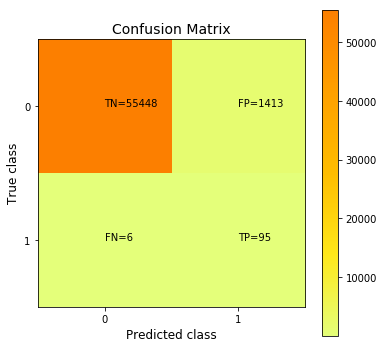

In [81]:
plot_confusion_matrix(cnf_matrix, title = "cnf_matrix", cmap = plt.cm.Wistia)

## Step 4: Comparison of the three models

Analysis based on the three confusions matrixs:

1. 对于原始的不平衡数据，accuracy 可能很高， recall_score (0.62) 很低， 对于我们想要identify 出的正例测出的很少
2. 下采样， recall_score (0.94),  代价是把很多负例探测成正例 （FP = 1756）,  这在实际情况中会增加我们很多工作量，比如银行将不是fraud的探测成fraud，银行需要一个一个调查.

3. 过采样， recall_score (0.92), 虽然recall_score 减少了一点点， 但是(FP = 1041), 工作了减少了很多

## Step 5: More analysis about Logistic Regression parameter (a) 阈值

In [0]:
def plot_confusion_a(cm, i, title = "Confusion matrix", cmap = plt.cm.Wistia ): # plt.cm.Wistia
  """
  This function prints and plots the confusion matrix
  """
  #plt.figure(figsize = (3, 3))
  plt.imshow(cm, interpolation = "nearest", cmap = cmap) # plt.cm.Blues
  plt.title("Threshold >=" + str(i), size = 12)
  #plt.colorbar()
  tick_marks = np.arange(2) # len(classes)
  plt.xticks(tick_marks,rotation = 0)
  plt.yticks(tick_marks,rotation = 0)
  if i in [0.8]:
    plt.xlabel('Predicted', size = 12)
  if i in [0.4]:
    plt.ylabel('True', size = 12)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
    for j in range(2):
      plt.text(j, i, str(cm[i][j]), size = 10) # str(s[i][j]+ " = " + 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Threshold = 0.1, Recall score = 0.9406
Threshold = 0.2, Recall score = 0.9703
Threshold = 0.3, Recall score = 0.9703
Threshold = 0.4, Recall score = 0.9604
Threshold = 0.5, Recall score = 0.9505
Threshold = 0.6, Recall score = 0.9406
Threshold = 0.7, Recall score = 0.9208
Threshold = 0.8, Recall score = 0.9208
Threshold = 0.9, Recall score = 0.9010


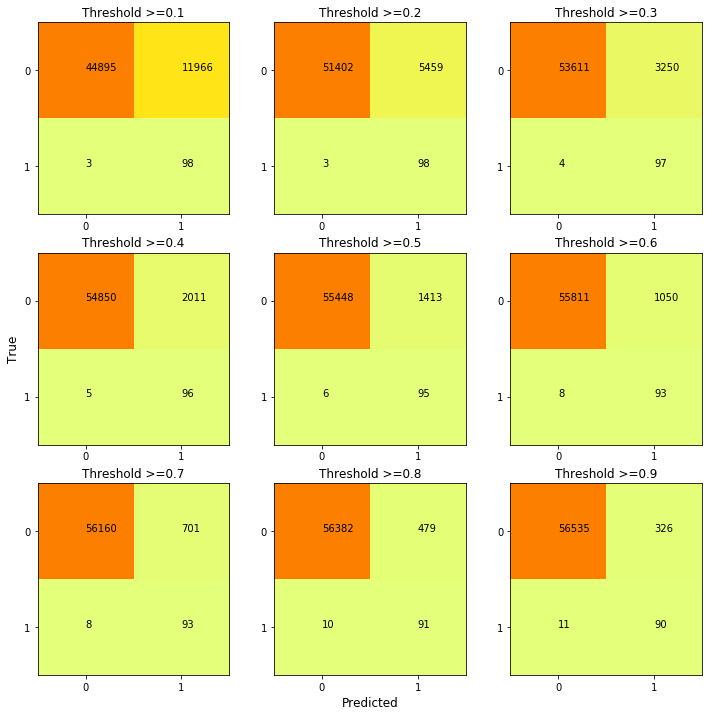

In [83]:
lr = LogisticRegression(C = best_c, penalty = "l1")
lr.fit(os_x, os_y)
y_pred_proba = lr.predict_proba(x_test)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize = (12, 12))

j = 1
for i in thresholds:
  print("Threshold = {}, Recall score = {:.4f}".format(i, cnf_matrix[1, 1]/(cnf_matrix[1, 0] + cnf_matrix[1, 1])))
  y_test_predictions_high_recall = y_pred_proba[:, 1] >= i
  plt.subplot(3, 3, j)
  j += 1
  # compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_test_predictions_high_recall)
  np.set_printoptions(precision = 2)
  plot_confusion_a(cnf_matrix, i, title = "Confusion matrix", cmap = plt.cm.Wistia)
  
  
plt.show()

## Useful reference:
URL_1 = "https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d" **GBM**

URL_2 = "https://github.com/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb" **GBM code from scratch to complete**